# GovContracts Transformer

In [2]:
from google.colab import drive

drive.mount("/content/drive")

Mounted at /content/drive


In [3]:
!pip install transformers

     |████████████████████████████████| 3.4 MB 5.0 MB/s 
     |████████████████████████████████| 3.3 MB 58.8 MB/s 
     |████████████████████████████████| 67 kB 7.6 MB/s 
     |████████████████████████████████| 596 kB 63.8 MB/s 
     |████████████████████████████████| 895 kB 66.6 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


## Liberias

In [33]:
import os
import re
import pickle
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from typing import List, Optional
from google.colab import files as download_file
from tensorflow.keras import (optimizers, layers,
                              Model, models,
                              utils)
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from transformers import (DistilBertConfig,
                          DistilBertTokenizer,
                          TFDistilBertForSequenceClassification)

In [5]:
os.chdir("/content/drive/MyDrive/GovContracts")

## Datos

In [6]:
df = pd.read_csv("data/keywords.csv")

df

,NAICS22,INDEX ITEM DESCRIPTION
0,111110,"Soybean farming, field and seed production"
1,111120,"Canola farming, field and seed production"
2,111120,"Flaxseed farming, field and seed production"
3,111120,"Mustard seed farming, field and seed production"
4,111120,"Oilseed farming (except soybean), field and se..."
...,...,...
20393,******,Stores -- see type
20394,******,Tailors -- see specific apparel manufacturing
20395,******,Therapists' offices -- see type
20396,******,Transportation -- see mode


### Eliminamos los *** de la tabla anterior

In [7]:
df = df[ pd.to_numeric( df['NAICS22'], errors = 'coerce').notnull() ]

### Definimos numero de clases

In [8]:
classes = len(df["NAICS22"].unique())

print(f"Numero total de clases: {classes}")

Numero total de clases: 1010


## Tratamiento de datos

### Eliminar signos

In [9]:
def signremove(text: str) -> str:
  remove_signs = lambda col: re.sub(r'[^\w]', " ", col )
  double_space = lambda col: re.sub('\s{2,}', " ", col)
  numbers = lambda col: re.sub(r'\w*\d+\w*', "", col)

  text = text.lower()
  text = remove_signs(text)
  text = numbers(text)
  text = double_space(text)

  return text

df["INDEX ITEM DESCRIPTION"] = df["INDEX ITEM DESCRIPTION"].apply(signremove)

df.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


,NAICS22,INDEX ITEM DESCRIPTION
0,111110,soybean farming field and seed production
1,111120,canola farming field and seed production
2,111120,flaxseed farming field and seed production
3,111120,mustard seed farming field and seed production
4,111120,oilseed farming except soybean field and seed ...


## Analysis

In [10]:
total_words = len(set(df["INDEX ITEM DESCRIPTION"].values))


samples_naics = np.unique(df["NAICS22"].values,
                         return_counts = True)

min_sample = min(samples_naics[1])
max_sample = max(samples_naics[1])

mean_sampling = np.mean(samples_naics[1])

print(f"Total know words: {total_words}, min sapmling of code: {min_sample}, max sample: {max_sample}, mean: {mean_sampling}")


Total know words: 20373, min sapmling of code: 1, max sample: 320, mean: 20.171287128712873


In [11]:
max_pos_code = np.where(samples_naics[1] == max_sample)[0]
min_pos_code =np.where(samples_naics[1] == min_sample)[0]

print(f"min codes sampling: { ', '.join(samples_naics[0][min_pos_code]) } with {min_sample} representations")

print(f"max codes sampling: {', '.join(samples_naics[0][max_pos_code])} with {max_sample} representations")

min codes sampling: 111110, 111140, 111160, 111191, 111310, 111331, 111333, 111336, 111910, 111991, 111992, 113110, 311811, 311830, 326160, 332117, 332721, 335921, 445131, 445291, 488111, 561613 with 1 representations
max codes sampling: 315250 with 320 representations


### Plots

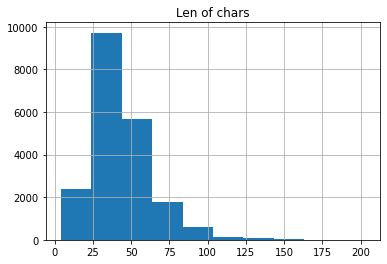

In [12]:
df['INDEX ITEM DESCRIPTION'].str.len().hist()
plt.title("Len of chars")
plt.show()

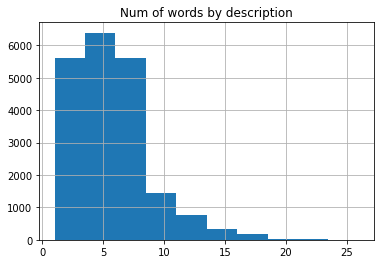

In [13]:
def plot_word_number_histogram(text):
    
    data = text.str.split().map(lambda x: len(x))

    data.hist()

    return data
  
num_words = plot_word_number_histogram(df['INDEX ITEM DESCRIPTION'])
plt.title("Num of words by description")
plt.show()

In [14]:
max(num_words)

26

## Spliting data

In [15]:
naics_codes = df['NAICS22']

keywords = list(df["INDEX ITEM DESCRIPTION"].values)

### Categorical output

In [16]:
encoder = LabelEncoder()
onehot = OneHotEncoder()

In [17]:
naics_codes_encoder = encoder.fit_transform(naics_codes.values)

naics_codes_encoder = naics_codes_encoder.reshape(-1, 1)

naics_codes_onehot = onehot.fit_transform(naics_codes_encoder).toarray()

### Saving encoders 

Nota: Los guardare en GovModel

In [18]:
pickle.dump(encoder, open('encoder.pkl',
                          'wb'))

pickle.dump(onehot, open('onehot.pkl',
                         'wb'))

## Model

### Transfer learning

In [19]:
model_name = "distilbert-base-uncased"

#### Tokenizer


In [20]:
tokenizer = DistilBertTokenizer.from_pretrained(model_name, do_lower_case = True,
                                                add_special_tokens = True,
                                                max_length = 512)

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

In [21]:
def tokenize(sentences: List[str], tokenizer):

  inputs_id, inputs_masks = list(), list()
  for sentence in tqdm(sentences):

    inputs = tokenizer.encode_plus(sentence, add_special_tokens = True,
                                   max_length = 512, return_token_type_ids = True,
                                   return_attention_mask = True,
                                   pad_to_max_length = True)
    
    inputs_id.append(inputs["input_ids"])

    inputs_masks.append(inputs['attention_mask'])

  return np.asarray(inputs_id, dtype='int32'), \
         np.asarray(inputs_masks, dtype='int32')

In [22]:
inputs_id, inputs_masks = tokenize(keywords,
                                   tokenizer)

  0%|          | 0/20373 [00:00<?, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2232: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
100%|██████████| 20373/20373 [00:07<00:00, 2780.11it/s]


In [23]:
inputs_id, inputs_masks

(array([[  101, 25176,  4783, ...,     0,     0,     0],
        [  101,  2064,  6030, ...,     0,     0,     0],
        [  101, 13109,  8528, ...,     0,     0,     0],
        ...,
        [  101,  2110,  2533, ...,     0,     0,     0],
        [  101,  2142,  3741, ...,     0,     0,     0],
        [  101,  2088,  2924, ...,     0,     0,     0]], dtype=int32),
 array([[1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        ...,
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0]], dtype=int32))

In [24]:
!ls

'Copia de Transformer.ipynb'   model.json    'Test tranformer.ipynb'
 data			       modelo.ipynb   Transformer.ipynb
 encoder.pkl		       modelos	      Transformer.png
 GovModel		       onehot.pkl


In [25]:
tokenizer.save_pretrained("GovModel")

('GovModel/tokenizer_config.json',
 'GovModel/special_tokens_map.json',
 'GovModel/vocab.txt',
 'GovModel/added_tokens.json')

#### Transformer

In [26]:
config = DistilBertConfig(num_labels = naics_codes_onehot.shape[-1])

config.output_hidden_states = False

transformer_model = TFDistilBertForSequenceClassification.from_pretrained(model_name,
                                                                          config = config)

Downloading:   0%|          | 0.00/347M [00:00<?, ?B/s]

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['vocab_layer_norm', 'vocab_projector', 'activation_13', 'vocab_transform']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['dropout_19', 'pre_classifier', 'classifier']
You should probably TRAIN this model on a down-stream task to be able to use i

### Input and output layers

In [27]:
def build_model(input_shape: Optional[int] = 512):

  input_id_layer = layers.Input(shape = (input_shape,),
                                dtype = 'int32',
                                name = "input_token")

  input_mask_layer = layers.Input(shape = (input_shape,),
                                  dtype = 'int32',
                                  name = "masked_token")

  transformer_block = transformer_model([input_id_layer, input_mask_layer])[0]

  normalization = layers.BatchNormalization(name = "batch_layer")(transformer_block)
  
  dropout = layers.Dropout(rate = 0.1,
                           name = "drop_layer")(normalization)

  out = layers.Dense(naics_codes_onehot.shape[-1],
                     activation = "softmax",
                     name = "output_layer")(dropout)

  model = Model(inputs = [input_id_layer, input_mask_layer],
                outputs = [out])
  
  return model
  
model = build_model()

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_token (InputLayer)       [(None, 512)]        0           []                               
                                                                                                  
 masked_token (InputLayer)      [(None, 512)]        0           []                               
                                                                                                  
 tf_distil_bert_for_sequence_cl  TFSequenceClassifie  67730162   ['input_token[0][0]',            
 assification (TFDistilBertForS  rOutput(loss=None,               'masked_token[0][0]']           
 equenceClassification)         logits=(None, 1010)                                               
                                , hidden_states=Non                                           

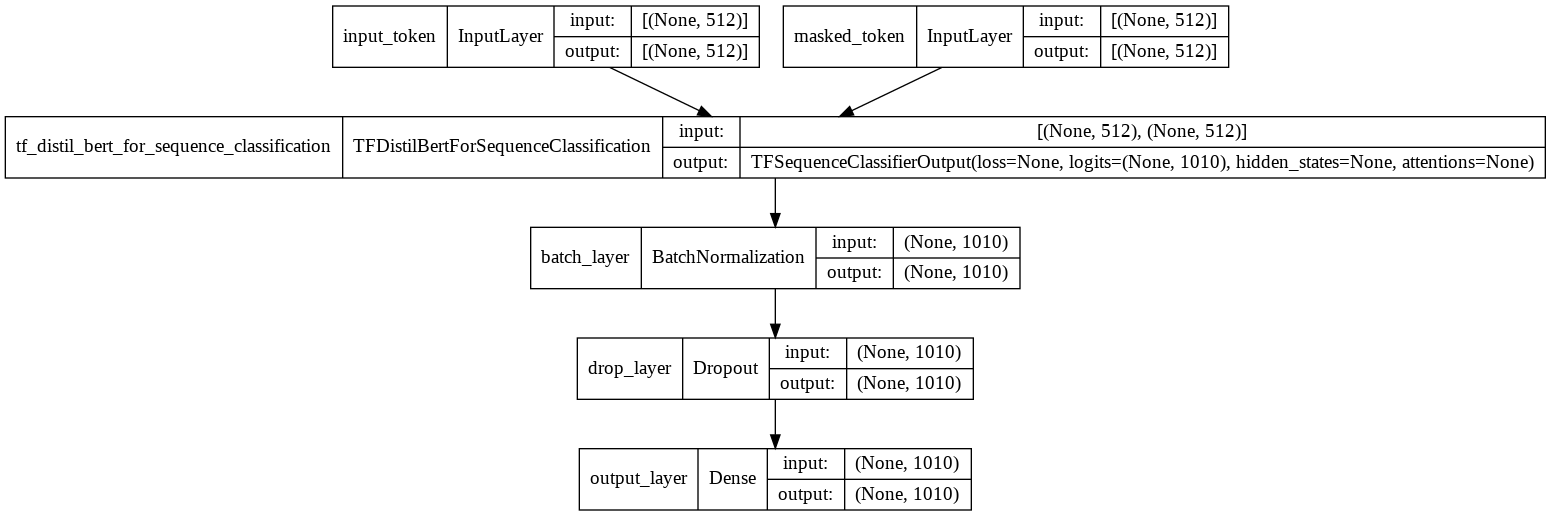

In [28]:
utils.plot_model(model, "Transformer.png",
                 show_shapes = True)

### Train model

In [30]:
model.compile(
    optimizer = optimizers.Adam(learning_rate = 5e-5),
    loss = "categorical_crossentropy",
    metrics = ["acc"]
)

history = model.fit(x = [inputs_id, inputs_masks],
                    y = naics_codes_onehot,
                    epochs = 4,
                    batch_size = 16,
                    )

Epoch 1/4
1274/1274 [==============================] - 1109s 865ms/step - loss: 3.8885 - acc: 0.3317
Epoch 2/4
1274/1274 [==============================] - 1108s 870ms/step - loss: 1.6032 - acc: 0.6485
Epoch 3/4
1274/1274 [==============================] - 1108s 870ms/step - loss: 0.8231 - acc: 0.8033
Epoch 4/4
1274/1274 [==============================] - 1107s 869ms/step - loss: 0.4515 - acc: 0.8934


### Saving model

In [32]:
model.save("sell2sam.h5")

In [36]:
json_model = model.to_json()

with open('sell2sam.json', 'w') as json_file:

    json_file.write(json_model)

In [37]:
model.save_weights('sell2sam_weights.h5')

### Test model

In [52]:
final_model = models.load_model("sell2sam/sell2sam.h5",
                                custom_objects = {"TFDistilBertForSequenceClassification":
                                                  transformer_model})

In [84]:
def tokenize(sentences: List[str], tokenizer):

  inputs_id, inputs_masks = list(), list()

  for sentence in tqdm(sentences):

    inputs = tokenizer.encode_plus(sentence, add_special_tokens = True,
                                   max_length = 512, return_token_type_ids = True,
                                   return_attention_mask = True,
                                   pad_to_max_length = True)
    
    inputs_id.append(inputs["input_ids"])

    inputs_masks.append(inputs['attention_mask'])

  return np.asarray(inputs_id, dtype='int32'), \
         np.asarray(inputs_masks, dtype='int32')     

inputs_id_test, inputs_masks_inputs_id_test = tokenize(["software"],
                                                          tokenizer)

  0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2232: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
100%|██████████| 1/1 [00:00<00:00, 564.21it/s]


In [85]:
preds = final_model.predict([inputs_id_test, inputs_masks_inputs_id_test])

y_preds = np.argsort(preds, axis=1)[:,-5:]

y_preds = y_preds[0]

encoder.inverse_transform(y_preds)

array(['924110', '518210', '423430', '541511', '513210'], dtype=object)

In [86]:
predsp = (preds * 100)

np.max(predsp)

64.831535